# Client/User B, Alice
In this jupyter notebook, we simulate how User B obtains the base_model from the server. After obtaining the base_model, User B trains the model on his data. Then,  weights were extracted from the Dense layer. These weights are encrypted, serialized and stored in a pickle file to send to the server. After getting the updated model from the server, User B check the new model's accuracy.

#### Import Libraries

In [33]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.metrics import confusion_matrix
import tenseal as ts
import pickle
from fractions import Fraction

## Creating User B's dataset. 
User B dataset consists of only digits 0 to 4 from the MNIST dataset. The dataset is split into 3 main parts: Server data, User B data and User B data.  
In this section, User's A data is made to contain only digits 0 to 4.

In [34]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


In [35]:
# Slicing the MNIST original dataset to retain only part of the dataset.
x_train = x_train[40596:,:,:]
y_train = y_train[40596:]
x_test = x_test[7139:,:,:]
y_test  = y_test[7139:]

In [36]:
# Length of the new dataset
print("x_train:",len(x_train))
print("y_train:",len(y_train))
print("x_test:",len(x_test))
print("y_test:",len(y_test))

x_train: 19404
y_train: 19404
x_test: 2861
y_test: 2861


In [37]:
# Filter the new dataset to retain only digits 5 to 9.
def filter_56789(x, y):
    keep = (y == 5) | (y == 6) | (y == 7)| (y == 8) | (y == 9)
    x, y = x[keep], y[keep]
    return x,y

In [38]:
# Filtered dataset
x_train, y_train = filter_56789(x_train, y_train)
x_test, y_test = filter_56789(x_test, y_test)
print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 9542
Number of filtered test examples: 1389


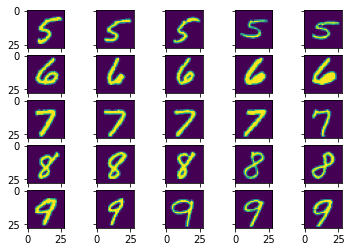

In [39]:
# Display a sample of the User B's dataset. 
digits = {}
for i in range(5):
    digits[i] = np.where(y_test==i+5)[0][:5]
#print(digits)

fig, ax = plt.subplots(5, 5, sharex='col', sharey='row')
for i in range(5):
    for j in range(5):
        ax[i, j].imshow(x_test[digits[i][j]])

## Getting the base model.  
In this section, we retrieve the base_model and train it on User B's data.

In [40]:
new_model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                7840      
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                100       
Total params: 7,940
Trainable params: 7,940
Non-trainable params: 0
_________________________________________________________________


In [41]:
# Creating a multiclass confusion matrix before training.
predictions = new_model.predict(x_test)
confusion = confusion_matrix(y_test, np.argmax(predictions,axis=1))
confusion

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  8,   2,   2,  15,   0, 211,   4,   2,   4,   1],
       [  2,   0,   1,   0,   0,   4, 279,   0,   1,   0],
       [  0,   0,   8,   3,   0,   0,   0, 289,   0,   3],
       [  1,   2,   2,   2,   2,  12,   0,   4, 245,   5],
       [  0,   0,   0,   0,   9,   0,   0,   8,   3, 255]], dtype=int64)

In [42]:
# Evaluate the base_model to see the loss and sparse_categorical_accuracy before training.
new_model.evaluate(x_test, y_test)

44/44 [==============================] - 0s 1ms/step - loss: 0.2514 - sparse_categorical_accuracy: 0.9208


e:\UDM\M2_privacyinAI\code_final\venv\lib\site-packages\keras\backend.py:4906: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


[0.25144335627555847, 0.920806348323822]

In [43]:
# Compiling the model.
new_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

In [44]:
# Retraining the base_model to obtain the new weights.
new_model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=100,
          verbose=1,
          validation_data=(x_test, y_test))

Epoch 1/100
75/75 [==============================] - 0s 3ms/step - loss: 0.5254 - sparse_categorical_accuracy: 0.8394 - val_loss: 0.1607 - val_sparse_categorical_accuracy: 0.9510
Epoch 2/100
75/75 [==============================] - 0s 2ms/step - loss: 0.4308 - sparse_categorical_accuracy: 0.8631 - val_loss: 0.1427 - val_sparse_categorical_accuracy: 0.9597
Epoch 3/100
75/75 [==============================] - 0s 2ms/step - loss: 0.3721 - sparse_categorical_accuracy: 0.8781 - val_loss: 0.1360 - val_sparse_categorical_accuracy: 0.9604
Epoch 4/100
75/75 [==============================] - 0s 2ms/step - loss: 0.3634 - sparse_categorical_accuracy: 0.8834 - val_loss: 0.1290 - val_sparse_categorical_accuracy: 0.9633
Epoch 5/100
75/75 [==============================] - 0s 2ms/step - loss: 0.3288 - sparse_categorical_accuracy: 0.8949 - val_loss: 0.1252 - val_sparse_categorical_accuracy: 0.9647
Epoch 6/100
75/75 [==============================] - 0s 2ms/step - loss: 0.3266 - sparse_categorical_accu

In [45]:
# Evaluate the base_model to see the loss and sparse_categorical_accuracy after training.
new_model.evaluate(x_test, y_test)

44/44 [==============================] - 0s 1ms/step - loss: 0.1264 - sparse_categorical_accuracy: 0.9662


[0.12635505199432373, 0.9661626815795898]

## Extracting weights & bias.

In [46]:
# Checking which layers have weights & bias.
for layer in new_model.layers:
    print(layer.name, len(layer.weights))

flatten 0
dense 1
dropout 0
dense_1 1


In [47]:
# Extracting User B's weights from the first Dense layer.
alice_weights = new_model.layers[1].get_weights()

## Masking the weights

In [48]:
K = -500
res_B = [(x + K) for x in alice_weights]
#print(" First tensor: Data = {}".format(res_B))

## Using CKKS to encrypt the weights.
In this section, we use Tenseal's CKKS class to encrypt the weights. Note that protobuf has a hardlimit of 2GB, hence, we split the weights into 2 arrays.

In [49]:
# Splitting the weights array into 2 arrays called 'arr0' and 'arr1'
arr = np.array(res_B)
arr0, arr1 = np.dsplit(arr, 2)
#(numpy.dstack((arr0, arr1))) == res_A  

In [50]:
# # Note that we use the generated key from key_query file.
# # Setup TenSEAL context.

# context = ts.context(
#             ts.SCHEME_TYPE.CKKS,
#             poly_modulus_degree=8192,
#             coeff_mod_bit_sizes=[60, 40, 40, 60]
#           )
          
# context.generate_galois_keys()
# context.global_scale = 2**40

# load : get the data from file
key_query_file = open('key_query', "rb")
context_key = pickle.load(key_query_file)
key_query_file.close()

# Recreate the key.
context = ts.context_from(context_key["context"])

In [51]:
# Encrypt the weights
enc_v1 = ts.ckks_tensor(context, arr0)
enc_v1_serialised = enc_v1.serialize()

In [52]:
# Encrypt the weights
enc_v2 = ts.ckks_tensor(context, arr1)
enc_v2_serialised = enc_v2.serialize()

In [53]:
# # Creating a copy of the context to share with the server. Ideally, the secret key should be drop.
# # Since we use the context from key_query file, no need to reserialise the key.

#public_context = context
#sk = context.secret_key()
#public_context.make_context_public()

# Context and ciphertext serialization
#server_context = public_context.serialize(save_secret_key=True)

# # Check is context is private.
#print("Is the context private?", ("Yes" if context.is_private() else "No"))

In [54]:
# Storing the weights and context in a dict so it can be sent as a JSON file.
alice_query = {
    "data1" : enc_v1_serialised,
    "data2" : enc_v2_serialised,
    #"context" : server_context
}


In [55]:
# Storing the encrypyted weights and context in a pickle file. 
# Note that this is done only to obtain the size of the encrypted weights on disk, and that pickle is not secure.
input_dictionary = (alice_query)
file = open('alice_enc', 'wb')
pickle.dump(input_dictionary, file)
file.close()

## Gentry FHE
In this section, we use our own implementation of Gentry's FHE schemne to encrypt the weights. 
Note that this is a basic implementation. 

In [56]:
r = 3
p = 29
q = 22
#encrypt mask weights A
encrypt_B = [(x + (2*r) + (q*p)) for x in res_B]


In [57]:
# We only stored the encrpyted weights in dict. Keys are stored separately.
Alice_query_gentry = {
    "data1" : encrypt_B,
}

In [58]:
# Storing the encrypyted weights and context in a pickle file. 
# Note that this is done only to obtain the size of the encrypted weights on disk, and that pickle is not secure.
import pickle
input_dictionary = (Alice_query_gentry)
file = open('Alice_enc_gentry', 'wb')
pickle.dump(input_dictionary, file)
file.close()

## Loading updated model.
In this section, we uload the updated model which have the averaged weights from the server.

In [59]:
updated_model = tf.keras.models.load_model('saved_model/updated_model')

# Check its architecture
updated_model.summary()
# Creating a multiclass confusion matrix before training.
predictions = updated_model.predict(x_test)
confusion = confusion_matrix(y_test, np.argmax(predictions,axis=1))
confusion

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                7840      
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                100       
Total params: 7,940
Trainable params: 7,940
Non-trainable params: 0
_________________________________________________________________


array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  6,   2,   2,  10,   0, 211,   7,   1,   8,   2],
       [  3,   1,   3,   0,   0,   2, 278,   0,   0,   0],
       [  0,   0,   7,   3,   0,   0,   0, 290,   0,   3],
       [  0,   4,   3,   2,   1,   9,   1,   2, 250,   3],
       [  0,   0,   0,   0,   9,   0,   1,   7,   3, 255]], dtype=int64)

In [60]:
# Evaluate the base_model to see the loss and sparse_categorical_accuracy before training.
updated_model.evaluate(x_test, y_test)
# Compiling the model.
updated_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)
# Retraining the base_model to obtain the new weights.
updated_model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=100,
          verbose=1,
          validation_data=(x_test, y_test))


44/44 [==============================] - 0s 3ms/step - loss: 0.2563 - sparse_categorical_accuracy: 0.9244


e:\UDM\M2_privacyinAI\code_final\venv\lib\site-packages\keras\backend.py:4906: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


Epoch 1/100
75/75 [==============================] - 0s 3ms/step - loss: 0.5355 - sparse_categorical_accuracy: 0.8283 - val_loss: 0.1745 - val_sparse_categorical_accuracy: 0.9467
Epoch 2/100
75/75 [==============================] - 0s 2ms/step - loss: 0.4265 - sparse_categorical_accuracy: 0.8634 - val_loss: 0.1497 - val_sparse_categorical_accuracy: 0.9554
Epoch 3/100
75/75 [==============================] - 0s 2ms/step - loss: 0.3717 - sparse_categorical_accuracy: 0.8780 - val_loss: 0.1317 - val_sparse_categorical_accuracy: 0.9604
Epoch 4/100
75/75 [==============================] - 0s 2ms/step - loss: 0.3524 - sparse_categorical_accuracy: 0.8847 - val_loss: 0.1239 - val_sparse_categorical_accuracy: 0.9654
Epoch 5/100
75/75 [==============================] - 0s 2ms/step - loss: 0.3304 - sparse_categorical_accuracy: 0.8879 - val_loss: 0.1184 - val_sparse_categorical_accuracy: 0.9647
Epoch 6/100
75/75 [==============================] - 0s 2ms/step - loss: 0.3061 - sparse_categorical_accu

In [61]:
# Evaluate the base_model to see the loss and sparse_categorical_accuracy after training.
updated_model.evaluate(x_test, y_test)

44/44 [==============================] - 0s 1ms/step - loss: 0.1117 - sparse_categorical_accuracy: 0.9712


[0.11171109229326248, 0.9712023138999939]